# BE Smart Cities
The purpose of this project is to design a house with two rooms, and model and simulate the thermal behaviour of the building. We will study this in both steady state and dynamic simulation. 

## Modeling of the rooms

The layout we chose for our rooms is the following : 

[insert rooms plan here]

## Hypothesis

For simplicity of the model, we make the following hypothesis : 
 - The thermal transfers are linear, and the radiation is approximated by a coefficient close to convection
 - Length and height of the walls are considered to be 10 times greater than the width. Therefore we consider that the thermal transfer is unidirectional, and temperature is uniform on every surface.
 - We only consider the exchanges between vertical walls, assuming the floor and ceiling are adiabatic, such as the two walls without door and windows
 - We consider the indoor surface equal to the outdoor surface
 


## Thermal model 

### Main parameters

The first step was to constitue the thermal model of the rooms, using several elements : 

- The outer walls are made out of two materials : concrete and insulation 
Their dimensions are 6 x 2.5 x 0.16 m. 

- The inner wall is made out of concrete only. 

- The windows are 0.6 x 0.8 x 0.02 m. Wall A is only glass (6 x 2.5 x 0.02 m). 

- The doors are 2.20 x 0.8 x 0.05 m.


In [1]:
import numpy as np
import pandas as pd
import dm4bem

L = 6
wall_height = 2.5
SA = L*wall_height       # m² surface area of the glass wall (wall A)
Swindow = 0.6*0.8 # For 1 window
Sdoor= 2.2*0.8 # For 1 door
SB_c = L*wall_height-Swindow
SC_c = L*wall_height-Swindow-Sdoor
SD_c = L* wall_height
SE_c = L*wall_height-Sdoor
SF_c = L* wall_height
SG_c = L*wall_height
S_c = S_i = SB_c + SC_c + SD_c + SE_c + SF_c + SG_c
S_g= SA + 2*Swindow
S_d = 2*Sdoor
width_wall=0.16
width_insulation=0.04
width_window=0.02
width_door=0.05


We filled in the thermo-physical properties of air, and of the 4 materials listed before.

In [2]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])


concrete = {'Conductivity': 1.046,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 657,           # J/(kg⋅K)
            'Width': 0.16,                   # m
            'Surface': S_c}            # m²


insulation = {'Conductivity': 0.0325,        # W/(m·K)
              'Density': 128.0,              # kg/m³
              'Specific heat': 1093,        # J/(kg⋅K)
              'Width': 0.04,                # m
              'Surface': S_i}          # m²


glass = {'Conductivity': 1,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.02,                     # m
         'Surface': S_g}                   # m²


door = {'Conductivity': 0.63,               # W/(m·K)
         'Density': 825,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': S_d}                   # m²
        

Conventional values for the convection coefficients for indoor and outdoor convection in W/(m²⋅K) are:

In [3]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

Advection in the rooms 

In [4]:
# ventilation flow rate
V = L*L*wall_height                 # m³, volume of air


ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * (V)    # m³/s, air infiltration


# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot


# P-controler gain
#Kp = 1e4            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
Kp = 0

### Electrical model of the rooms

We then drew the equivalent eletrical schema of our room and numbered each node (from 0 to 20) and each resistance (from 0 to 25). We added the sun irradiation and internal irradiation (electrical devices, users of the rooms…). 


[insert schema here]


In [5]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11', 'θ12', 'θ13', 'θ14', 'θ16', 'θ17', 'θ18', 'θ19', 'θ20']


# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 'q25']


# temperature nodes
nθ = 20      # number of temperature nodes
#θ = [f'θ{i}' for i in range(nθ)]

print(θ)

# flow-rate branches
nq = 26     # number of flow branches
q = [f'q{i}' for i in range(nq)]

['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11', 'θ12', 'θ13', 'θ14', 'θ16', 'θ17', 'θ18', 'θ19', 'θ20']


### Computation of matrices
The next step was to compute every value of conductance for convection and conduction and fill the conductance diagonal matrix G, the capacity diagonal matrix C, the incidence matrix A, the temperature source vector b and the heat flow source vector f

In [6]:
G = np.array(np.hstack(
    [h['out']*SB_c,
     2 * concrete['Conductivity']*SB_c/width_wall, 2 * concrete['Conductivity']*SB_c/width_wall,
     2 * insulation['Conductivity']/width_insulation*SB_c, 2 * insulation['Conductivity']/width_insulation*SB_c,
     h['in']*SB_c,
     h['out']*SC_c,
     2 * concrete['Conductivity']/width_wall*SC_c, 2 * concrete['Conductivity']/width_wall*SC_c,
     2 * insulation['Conductivity']/width_insulation*SC_c, 2 * insulation['Conductivity']/width_insulation*SC_c,
     h['in']*SC_c,
     h['out']*SE_c,
     2 * concrete['Conductivity']/width_wall*SE_c, 2 * concrete['Conductivity']/width_wall*SE_c,
     2 * insulation['Conductivity']/width_insulation*SE_c, 2 * insulation['Conductivity']/width_insulation*SE_c,
     h['in']*SE_c,
     Gv + (h['out']+h['in'])*(SA+Sdoor) + glass['Conductivity']/width_window*SA + door['Conductivity']/width_door*Sdoor,
     Gv + (h['out']+h['in'])*(2*Swindow+Sdoor) + 2*(glass['Conductivity']/width_window*Swindow) + door['Conductivity']/width_door*Sdoor,
     Kp,
     h['in']*SG_c,
     2 * concrete['Conductivity']/width_wall*SG_c, 2 * concrete['Conductivity']/width_wall*SG_c,
     h['in']*SG_c,
     Kp]))


G_matrix=np.zeros((nq,nq))
for i in range (nq):
   G_matrix[i,i]=G[i]

pd.DataFrame(G, index=q)



# C=np.zeros((nθ,nθ))
# C[1,1] = concrete["Density"]*concrete["Specific heat"]*width_wall*SB_c
# C[3,3]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SB_c
# C[6,6]=concrete["Density"]*concrete["Specific heat"]*width_wall*SC_c
# C[8,8]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SC_c
# C[11,11] = concrete["Density"]*concrete["Specific heat"]*width_wall*SE_c
# C[13,13]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SE_c
# C[16,16]=concrete["Density"]*concrete["Specific heat"]*width_wall*SG_c

C=np.zeros(nθ)
neglect_air_glass = False

if neglect_air_glass:
    C[1] = concrete["Density"]*concrete["Specific heat"]*width_wall*SB_c
    C[3]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SB_c
    C[6]=concrete["Density"]*concrete["Specific heat"]*width_wall*SC_c
    C[8]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SC_c
    C[11] = concrete["Density"]*concrete["Specific heat"]*width_wall*SE_c
    C[13]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SE_c
    C[15]=concrete["Density"]*concrete["Specific heat"]*width_wall*SG_c
    
else:
    C[1] = concrete["Density"]*concrete["Specific heat"]*width_wall*SB_c
    C[3]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SB_c
    C[6]=concrete["Density"]*concrete["Specific heat"]*width_wall*SC_c
    C[8]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SC_c
    C[11] = concrete["Density"]*concrete["Specific heat"]*width_wall*SE_c
    C[13]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SE_c
    C[15]=concrete["Density"]*concrete["Specific heat"]*width_wall*SG_c
    

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)



A=np.zeros((nq,nθ))
for i in range (0,5):
   A[i,i]=1
   A[i+1, i]=-1
for i in range(5, 10):
   A[i+1, i] = 1
   A[i+2, i] = -1


for i in range(10, 15):
   A[i+2, i] = 1
   A[i+3, i] = -1


A[22,15]=1
A[23,15]=1
A[5,16]=1
A[11,16]=1
A[19,16]=1
A[20,16]=-1
A[21,16]=-1
A[17,17]=1
A[18,17]=1
A[24,17]=-1
A[21,18]=1
A[22,18]=-1
A[23,19]=-1
A[24,19]=1
A[25,17]=-1


pd.DataFrame(A, index=q, columns=θ)


#To is Text, input from the DB
b = pd.Series(['To', 0, 0, 0, 0, 0, 'To', 0, 0, 0, 0, 0, 'To', 0, 0, 0, 0, 0, 'To', 'To', 'Ti_sp', 0, 0, 0, 0, 'Ti_sp'],
             index=q)


# Φo - solar radiation absorbed by the outdoor surface of the wall, W;
# Φi - solar radiation absorbed by the indoor surface of the wall, W;
# Qa - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W; A VERIFIER


f = pd.Series(['Φo', 0, 0, 0, 'Φi', 'Φo',0,0, 0, 'Φi', 'Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Qa', 'Φi', 'Φi'], index=θ)



y = np.zeros(nθ)         # nodes
y[[17]] = 1              # nodes (temperatures) of interest
y[[18]] = 1
pd.DataFrame(y, index=θ)


# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)


TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

In [7]:
# On part du dictionnaire TC déjà existant
A = TC["A"].copy()
G = TC["G"]
b = TC["b"]
C = TC["C"]
f = TC["f"]
y = TC["y"]


# On ajoute les colonnes G et b à la matrice A
A["G"] = G
A["b"] = b


# S'assurer que les colonnes de A sont bien définies
cols = list(A.columns)

# Ajouter la ligne 'C' (vecteur)
A.loc["C"] = pd.Series(C, index=cols).astype("object")

# Ajouter la ligne 'f' (texte)
A.loc["f"] = pd.Series(f, index=cols).astype("object")

# Ajouter la ligne 'y' (vecteur booléen ou 0/1)
A.loc["y"] = pd.Series(y, index=cols).astype("object")

# Sauvegarde en CSV
A.to_csv("modele_thermique.csv")


## Steady-state response

Steady-state analysis focuses on the behavior of a system after transients have settled, specifically when the system reaches a stable equilibrium at a constant input.

For this first resolution, we assume : 
The indoor air temperature is controlled or not (i.e., the building is in free running).

The heat capacity of air and of glass is neglected or not.

The time step is calculated from the eigenvalues or it is imposed at a value designated as Δt.

In [8]:
controller = False
neglect_air_glass_capacity = False
imposed_time_step = False
Δt = 498    # s, imposed time step

In [9]:
print('Matrices and vectors for thermal circuit from Figure 1') 
df = pd.read_csv('./modele_thermique.csv')
df.style.apply(lambda x: ['background-color: yellow'
                          if x.name in df.index[-3:] or c in df.columns[-2:]
                          else '' for c in df.columns], axis=1)

Matrices and vectors for thermal circuit from Figure 1


,Unnamed: 0,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8,θ9,θ10,θ11,θ12,θ13,θ14,θ16,θ17,θ18,θ19,θ20,G,b
0,q0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,363.000000,To
1,q1,-1.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,189.849000,0
2,q2,0.0,-1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,189.849000,0
3,q3,0.0,0.000000,-1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,23.595000,0
4,q4,0.0,0.000000,0.000000,-1.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,23.595000,0
5,q5,0.0,0.000000,0.000000,0.000000,-1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,116.160000,0
6,q6,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,319.000000,To
7,q7,0.0,0.000000,0.000000,0.000000,0.0,-1.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,166.837000,0
8,q8,0.0,0.000000,0.000000,0.000000,0.0,0.0,-1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,166.837000,0
9,q9,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,20.735000,0


In [10]:
# MODEL
# =====
# Thermal circuit
TC = dm4bem.file2TC('./modele_thermique.csv', name='', auto_number=False)

# by default TC['G']['q20'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q20'] = 1e3        # Kp -> ∞, almost perfect controller
    TC['G']['q26'] = 1e3        # Kp -> ∞, almost perfect controller

if neglect_air_glass_capacity:
    C[1] = concrete["Density"]*concrete["Specific heat"]*width_wall*SB_c
    C[3]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SB_c
    C[6]=concrete["Density"]*concrete["Specific heat"]*width_wall*SC_c
    C[8]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SC_c
    C[11] = concrete["Density"]*concrete["Specific heat"]*width_wall*SE_c
    C[13]=insulation["Density"]*insulation["Specific heat"]*width_insulation*SE_c
    C[16]=concrete["Density"]*concrete["Specific heat"]*width_wall*SG_c

print('Matrices and vectors for thermal circuit from Figure 1') 
df = pd.read_csv('./modele_thermique.csv')
df.style.apply(lambda x: ['background-color: yellow'
                          if x.name in df.index[-3:] or c in df.columns[-2:]
                          else '' for c in df.columns], axis=1)

Matrices and vectors for thermal circuit from Figure 1


,Unnamed: 0,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8,θ9,θ10,θ11,θ12,θ13,θ14,θ16,θ17,θ18,θ19,θ20,G,b
0,q0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,363.000000,To
1,q1,-1.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,189.849000,0
2,q2,0.0,-1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,189.849000,0
3,q3,0.0,0.000000,-1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,23.595000,0
4,q4,0.0,0.000000,0.000000,-1.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,23.595000,0
5,q5,0.0,0.000000,0.000000,0.000000,-1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,116.160000,0
6,q6,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,319.000000,To
7,q7,0.0,0.000000,0.000000,0.000000,0.0,-1.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,166.837000,0
8,q8,0.0,0.000000,0.000000,0.000000,0.0,0.0,-1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,166.837000,0
9,q9,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,20.735000,0


In [11]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)


In [12]:
bss = np.zeros(nq)        # temperature sources b for steady state
bss[[0, 6, 12, 18, 19]] = 10      # outdoor temperature
bss[[20, 25]] = 20            # indoor set-point temperature

f = pd.Series(['Φo', 0, 0, 0, 'Φi', 'Φo',0,0, 0, 'Φi', 'Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Qa','Φi','Φi'], index=θ)

fss = np.zeros(nθ)         # flow-rate sources f for steady state

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')


θss = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.] °C


In [13]:
bss = np.zeros(nq)        # temperature sources b for steady state

fss = np.zeros(nθ)         # flow-rate sources f for steady state
fss[[16,17]] = 1000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

θssQ = [0.11 0.32 0.52 2.2  3.87 0.11 0.32 0.52 2.2  3.87 0.02 0.06 0.1  0.43
 0.76 2.52 4.21 0.83 3.16 1.88] °C


In [14]:
#bT = np.array([10, 10, 10, 10, 10, 20, 20])     # [To, To, To, To, To, Tisp, Tisp]
bT = np.array([10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 10, 20, 0, 0, 0, 0, 20])
#bT = np.array([0, 0, 0, 0, 0, 0, 0])
#fQ_old = np.array(['Φo', 'Φi', 'Φo', 'Φi', 'Φo', 'Φi', 'Qa', 'Qa','Φi','Φi'])

fQ = np.array([0,0,0,0,0,0,0,0,0,0])

uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

uss = [10  0  0  0  0  0 10  0  0  0  0  0 10  0  0  0  0  0 10 10 20  0  0  0
  0 20  0  0  0  0  0  0  0  0  0  0]


In [15]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

In [16]:
# time step
Δtmax = 2 * min(-1. / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

Δtmax = 3976 s = 1.1 h
dt = 3600 s = 60.0 min


In [17]:
if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

In [18]:
# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

t_settle = 116815 s = 32.4 h


In [19]:
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

duration = 118800 s = 33.0 h


In [20]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)
us_new = pd.Series(['To','To','To','To','To','Ti_sp','Ti_sp','Φo','Φi','Φo','Φi','Φo','Φi','Qa','Qa','Φi','Φi'])

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us_new, input_data_set)


In [29]:
# Initial conditions
state_names = Bs.index

θ_exp = pd.DataFrame(index=u.index, columns=state_names)
θ_imp = pd.DataFrame(index=u.index, columns=state_names)

θ0 = 0.0
θ_exp.iloc[0] = θ0
θ_imp.iloc[0] = θ0

# sécuriser l'ordre des colonnes de u pour aligner avec Bs
u_aligned = u.reindex(columns=Bs.columns)

I = np.eye(len(state_names))  # ou As.shape[0]

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As) @ θ_exp.iloc[k] + dt * Bs @ u_aligned.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp.iloc[k] + dt * Bs @ u_aligned.iloc[k])


In [39]:
# outputs
θ_exp_T = θ_exp.T.reindex(index=Cs.columns)
θ_imp_T = θ_imp.T.reindex(index=Cs.columns)
u_T = u.T.reindex(index=Ds.columns)
y_exp = (Cs @ θ_exp_T + Ds @ u_T).T
y_imp = (Cs @ θ_imp_T + Ds @ u_T).T# plot results
print(TC['y'][TC['y'] != 0])
u.describe()
θ_exp.tail()

θ18    1.0
θ19    1.0
Name: y, dtype: float64


,θ1,θ3,θ6,θ8,θ11,θ13,θ16
2000-01-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


θ18    1.0
θ19    1.0
Name: y, dtype: float64


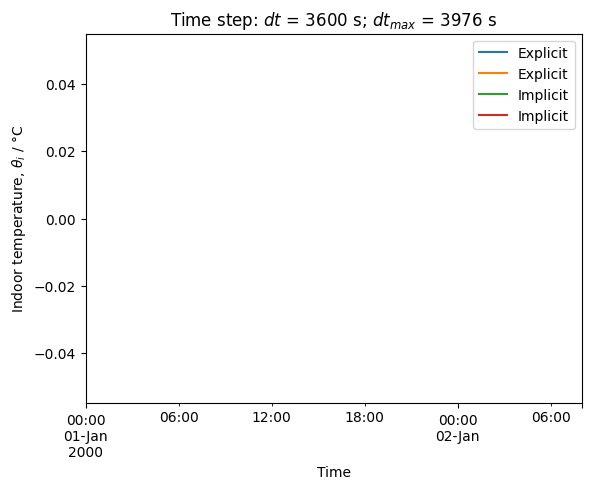

In [38]:
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

The results of the steady-state response are summed-up below : 

In [36]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θss[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ6"].tail(1).values[0]:.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C


NameError: name 'yss' is not defined

## Step response to internal load

In this part, we study the step response of the model, considering that the temperature sources are zero and that the flow-rate sources are zero, with the exception of the auxiliary heat gains $\dot{Qa}$.

In [ ]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")
# Create input_data_set
To = 0 * np.ones(n)         # outdoor temperature
Ti_sp =  20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo = Φi = Φa                # solar radiation
Qa = 1000 * np.ones(n)      # auxiliary heat sources
data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us_new, input_data_set)

In [ ]:
# Initial conditions
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [ ]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

In [ ]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

The results of the step response are summed-up below : 

In [ ]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θssQ[6]):.4f} °C')
print(f'- state-space model: {float(yssQ):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ6"].tail(1).values[0]:.4f} °C')